In [ ]:
import os, random, numpy as np, pandas as pd, shap, matplotlib.pyplot as plt, warnings
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict
from scipy.io import arff
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")

try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None
try:
    from lightgbm import LGBMClassifier
except Exception:
    LGBMClassifier = None
try:
    from catboost import CatBoostClassifier
except Exception:
    CatBoostClassifier = None

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

def set_seed(s: Optional[int]):
    if s is None: return
    random.seed(s); np.random.seed(s); os.environ["PYTHONHASHSEED"]=str(s); torch.manual_seed(s)

def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    bad = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if bad: X.drop(columns=bad, inplace=True)
    if X.isna().any().any(): X = X.fillna(method="ffill").fillna(method="bfill")
    return X

def to_numeric_features_only(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            try: df[c] = pd.to_numeric(df[c], errors="ignore")
            except Exception: pass
    return df.select_dtypes(include=[np.number])

def _to_float32(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_float_dtype(df[c]): df[c] = df[c].astype(np.float32)
    return df

def _mean_abs_by_feature(sv, n_features: int) -> np.ndarray:
    if isinstance(sv, list):
        arr = np.asarray(sv[1] if len(sv)>=2 else sv[0])
    else:
        arr = np.asarray(sv)
    if arr.ndim==2 and arr.shape[1]==n_features:
        return np.abs(arr).mean(axis=0)
    feat_axes = [ax for ax,d in enumerate(arr.shape) if d==n_features]
    if feat_axes:
        arr = np.moveaxis(arr, feat_axes[0], -1)
        return np.abs(arr).mean(axis=tuple(range(arr.ndim-1)))
    return np.abs(arr.reshape(-1, n_features)).mean(axis=0)

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a,b = a.align(b, join="inner")
    return spearmanr(a.values, b.values).correlation if len(a) else np.nan

def rescale01_rho(rho: float) -> float:
    return np.nan if np.isnan(rho) else 0.5*(rho+1)

def _decode_bytes_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object and len(df[c])>0 and isinstance(df[c].iloc[0], (bytes, bytearray)):
            df[c] = df[c].apply(lambda x: x.decode("utf-8", "ignore") if isinstance(x, (bytes, bytearray)) else x)
    return df

def _binarize_target(y: pd.Series) -> pd.Series:
    y = y.copy()
    if pd.api.types.is_numeric_dtype(y):
        uniq = pd.unique(y)
        if len(uniq) > 2: return (y.astype(float) > 0).astype(int)
        vals = set(pd.unique(y))
        if vals.issubset({0,1}): return y.astype(int)
        if vals.issubset({1,2}): return (y.astype(int) == 2).astype(int)
        return (y.astype(float) > 0).astype(int)
    y_ = y.astype(str).str.strip().str.lower()
    truthy = {"true","y","yes","defect","defects","bug","bugs","t","1"}
    falsy  = {"false","n","no","clean","f","0"}
    return y_.apply(lambda v: 1 if (v in truthy) else (0 if v in falsy else (1 if v not in falsy else 0))).astype(int)

def _predict_proba_clipped(model, cols):
    def _f(Z):
        if isinstance(Z, np.ndarray):
            Z = pd.DataFrame(Z, columns=cols)
        p = model.predict_proba(Z)[:, 1]
        p = np.clip(p, 1e-6, 1-1e-6)
        return np.c_[1-p, p]
    return _f

def _ensure_df(X, cols: List[str]) -> pd.DataFrame:
    if isinstance(X, pd.DataFrame):
        return X[cols] if list(X.columns) != list(cols) else X
    return pd.DataFrame(np.asarray(X), columns=cols)

def _kmeans_background(df: pd.DataFrame, k: int, rng=np.random.RandomState(0)) -> pd.DataFrame:
    df = _ensure_df(df, list(df.columns))
    try:
        obj = shap.kmeans(df, k=k)
        X = getattr(obj, "data", obj)
        return _ensure_df(X, list(df.columns))
    except Exception:
        idx = rng.choice(len(df), size=min(len(df), k), replace=False)
        return df.iloc[idx].copy()

@dataclass
class PipelineConfig:
    target_col: Optional[str] = None
    rng: int = 42
    n_splits: int = 5
    use_smote: bool = True
    smote_k_max: int = 5
    # SHAP
    shap_background_size: int = 1024
    shap_eval_size: int = 6000
    shap_nsamples: int = 300
    shap_mode: str = "auto"      # "auto" | "disable"
    fast_mode: bool = True
    fast_shap_k: int = 64
    # Concordance / Permutation
    perm_repeats: int = 15
    perm_max_features: Optional[int] = None
    concordance_top_k: int = 25
    # RandomForest (unchanged)
    rf_n_estimators: int = 800
    rf_max_depth: Optional[int] = 12
    rf_min_samples_leaf: int = 3
    # Ensembles
    et_n_estimators: int = 800
    gb_learning_rate: float = 0.05
    gb_n_estimators: int = 400
    ab_n_estimators: int = 400
    # XGB / LGBM / CatBoost
    xgb_n_estimators: int = 600
    xgb_max_depth: int = 6
    xgb_learning_rate: float = 0.05
    lgb_n_estimators: int = 700
    lgb_num_leaves: int = 63
    lgb_learning_rate: float = 0.05
    cb_iterations: int = 700
    cb_depth: int = 6
    cb_learning_rate: float = 0.05
    # MLP (PyTorch)
    mlp_hidden: int = 128
    mlp_layers: int = 2
    mlp_dropout: float = 0.15
    mlp_epochs: int = 20
    mlp_batch_size: int = 512
    mlp_lr: float = 1e-3
    mlp_weight_decay: float = 1e-5

BASE_DATA_DIR = "./../../dataset"
DATASET_REGISTRY: Dict[str, Dict[str, Optional[str]]] = {
    "CM1": {"path": os.path.join(BASE_DATA_DIR, "CM1.csv"), "target": "Defective"},
    "PC1": {"path": os.path.join(BASE_DATA_DIR, "pc1.arff"), "target": None},
    "PC2": {"path": os.path.join(BASE_DATA_DIR, "pc2.arff"), "target": None},
    "PC3": {"path": os.path.join(BASE_DATA_DIR, "pc3.arff"), "target": None},
    "PC4": {"path": os.path.join(BASE_DATA_DIR, "pc4.arff"), "target": None},
    "MC1": {"path": os.path.join(BASE_DATA_DIR, "mc1.arff"), "target": None},
    "MC2": {"path": os.path.join(BASE_DATA_DIR, "mc2.arff"), "target": None},
    "MW1": {"path": os.path.join(BASE_DATA_DIR, "mw1.arff"), "target": None},
}
TARGET_CANDIDATES = ["Defective","defective","defects","bug","bugs","class","label","target","c"]

def _resolve_dataset(dataset: str) -> Tuple[str, Optional[str]]:
    if os.path.exists(dataset):
        return dataset, None
    key = dataset.strip().upper()
    if key in DATASET_REGISTRY:
        entry = DATASET_REGISTRY[key]
        return entry["path"], entry.get("target")
    raise FileNotFoundError(f"Dataset '{dataset}' not found as path or alias. Known aliases: {list(DATASET_REGISTRY.keys())}")

def _read_csv(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, header=None)
        hdr = df.iloc[0].astype(str).tolist()
        if len(set(hdr)) == len(hdr):
            df2 = df.iloc[1:].copy(); df2.columns = hdr; return df2
        df.columns = [f"col_{i}" for i in range(df.shape[1])]
        return df

def _read_arff(path: str) -> pd.DataFrame:
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    return _decode_bytes_cols(df)

def _auto_find_target(df: pd.DataFrame, hint: Optional[str]) -> str:
    if hint and hint in df.columns: return hint
    lowmap = {c.lower(): c for c in df.columns}
    for k in TARGET_CANDIDATES:
        if k.lower() in lowmap: return lowmap[k.lower()]
    return df.columns[-1]

def load_dataset(dataset: str, target_col: Optional[str]=None) -> Tuple[pd.DataFrame, pd.Series]:
    path, suggested = _resolve_dataset(dataset)
    ext = os.path.splitext(path)[1].lower()
    if ext == ".csv": df = _read_csv(path)
    elif ext == ".arff": df = _read_arff(path)
    else: raise ValueError(f"Unsupported file type: {ext} (expected .csv or .arff)")
    tgt = target_col or _auto_find_target(df, suggested)
    if tgt not in df.columns:
        raise ValueError(f"Target '{tgt}' not found in {os.path.basename(path)}. Available: {list(df.columns)}")
    y = _binarize_target(df[tgt].copy())
    X = to_numeric_features_only(df.drop(columns=[tgt]).copy())
    return X, y

class BaseModel:
    def __init__(self, cfg: PipelineConfig, random_state: int):
        self.cfg = cfg; self._cols: List[str] = []
    def fit(self, X: pd.DataFrame, y: pd.Series): raise NotImplementedError
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray: raise NotImplementedError
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series: raise NotImplementedError
    def permutation_importance_stable(self, X: pd.DataFrame, y: pd.Series) -> pd.Series:
        cols = self._cols; nrep = self.cfg.perm_repeats
        base_auc = roc_auc_score(y, self.predict_proba(X)[:,1])
        rsum = np.zeros(len(cols)); rng0 = np.random.RandomState(1)
        for r in range(nrep):
            rng = np.random.RandomState(rng0.randint(1_000_000))
            deltas = []
            for c in cols:
                Xp = X.copy(); Xp[c] = rng.permutation(Xp[c].values)
                auc_p = roc_auc_score(y, self.predict_proba(Xp)[:,1])
                deltas.append(max(base_auc - auc_p, 0.0))
            ranks = pd.Series(deltas, index=cols).rank(pct=True)
            rsum += ranks.values
        return pd.Series(rsum/nrep, index=cols, name="perm_rank")

class SklearnTreeLike(BaseModel):
    def __init__(self, estimator, cfg: PipelineConfig, random_state: int):
        super().__init__(cfg, random_state); self.model = estimator
    def fit(self, X: pd.DataFrame, y: pd.Series):
        X = _to_float32(X); self._cols = list(X.columns); self.model.fit(X[self._cols], y); return self
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        X = _ensure_df(X, self._cols); X = _to_float32(X); return self.model.predict_proba(X[self._cols])
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        if getattr(self.cfg, "shap_mode", "auto") == "disable":
            return pd.Series(dtype=float)
        cols = self._cols; rng = np.random.RandomState(0)
        k = min(self.cfg.fast_shap_k, max(1, len(X_bg))) if self.cfg.fast_mode else min(256, max(1, min(len(X_bg), self.cfg.shap_background_size)))
        bg = _kmeans_background(_ensure_df(X_bg, cols), k=k, rng=rng)
        X_eval = _ensure_df(X_eval, cols)
        if len(X_eval) > self.cfg.shap_eval_size:
            X_eval = X_eval.iloc[rng.choice(len(X_eval), size=self.cfg.shap_eval_size, replace=False)]
        try:
            expl = shap.TreeExplainer(self.model, data=bg, feature_perturbation="tree_path_dependent", model_output="probability")
            sv = expl.shap_values(X_eval, check_additivity=False)
        except Exception:
            f = _predict_proba_clipped(self.model, list(bg.columns))
            expl = shap.KernelExplainer(f, bg, link="identity")
            ns = self.cfg.shap_nsamples if not self.cfg.fast_mode else max(100, self.cfg.shap_nsamples//2)
            sv = expl.shap_values(X_eval, nsamples=ns)
        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

class RandomForestModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = RandomForestClassifier(
            n_estimators=cfg.rf_n_estimators, max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf, random_state=random_state,
            n_jobs=-1, class_weight="balanced_subsample", bootstrap=True
        )
        super().__init__(est, cfg, random_state)

class ExtraTreesModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = ExtraTreesClassifier(
            n_estimators=cfg.et_n_estimators, max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf, random_state=random_state,
            n_jobs=-1, class_weight="balanced_subsample", bootstrap=False
        )
        super().__init__(est, cfg, random_state)

class GradientBoostingModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = GradientBoostingClassifier(
            learning_rate=cfg.gb_learning_rate, n_estimators=cfg.gb_n_estimators, max_depth=3, random_state=random_state
        )
        super().__init__(est, cfg, random_state)

class AdaBoostModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = AdaBoostClassifier(
            n_estimators=cfg.ab_n_estimators, learning_rate=0.05, random_state=random_state
        )
        super().__init__(est, cfg, random_state)

class XGBModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if XGBClassifier is None: raise ImportError("xgboost is not installed. pip install xgboost")
        est = XGBClassifier(
            n_estimators=cfg.xgb_n_estimators, max_depth=cfg.xgb_max_depth, learning_rate=cfg.xgb_learning_rate,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, reg_alpha=0.0,
            eval_metric="logloss", random_state=random_state, n_jobs=-1
        )
        super().__init__(est, cfg, random_state)

class LGBMModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if LGBMClassifier is None: raise ImportError("lightgbm is not installed. pip install lightgbm")
        est = LGBMClassifier(
            n_estimators=cfg.lgb_n_estimators, num_leaves=cfg.lgb_num_leaves, learning_rate=cfg.lgb_learning_rate,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, random_state=random_state, n_jobs=-1,
            class_weight="balanced"
        )
        super().__init__(est, cfg, random_state)

class CatBoostModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if CatBoostClassifier is None: raise ImportError("catboost is not installed. pip install catboost")
        est = CatBoostClassifier(
            iterations=cfg.cb_iterations, depth=cfg.cb_depth, learning_rate=cfg.cb_learning_rate,
            loss_function="Logloss", verbose=False, random_state=random_state, eval_metric="AUC",
            auto_class_weights="Balanced"
        )
        super().__init__(est, cfg, random_state)

class TorchMLP(nn.Module):
    def __init__(self, d_in: int, hidden: int, layers: int, dropout: float):
        super().__init__()
        blocks = []
        d = d_in
        for _ in range(layers):
            blocks += [nn.Linear(d, hidden), nn.ReLU(inplace=True), nn.Dropout(dropout)]
            d = hidden
        blocks += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*blocks)
    def forward(self, x): return self.net(x).squeeze(1)

class MLPModel(BaseModel):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        super().__init__(cfg, random_state); self.model=None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def fit(self, X: pd.DataFrame, y: pd.Series):
        X = _to_float32(X); self._cols = list(X.columns)
        Xv = torch.tensor(X[self._cols].values, dtype=torch.float32)
        yv = torch.tensor(y.values.astype(np.float32), dtype=torch.float32)
        ds = TensorDataset(Xv, yv)
        dl = DataLoader(ds, batch_size=self.cfg.mlp_batch_size, shuffle=True, drop_last=False)
        self.model = TorchMLP(d_in=Xv.shape[1], hidden=self.cfg.mlp_hidden, layers=self.cfg.mlp_layers, dropout=self.cfg.mlp_dropout).to(self.device)
        opt = torch.optim.Adam(self.model.parameters(), lr=self.cfg.mlp_lr, weight_decay=self.cfg.mlp_weight_decay)
        pos = float((y==1).mean()); w_pos = 0.5/max(pos,1e-3); w_neg = 0.5/max(1-pos,1e-3)
        for _ in range(self.cfg.mlp_epochs):
            self.model.train()
            for xb, yb in dl:
                xb = xb.to(self.device); yb = yb.to(self.device)
                logits = self.model(xb)
                w = torch.where(yb>0.5, torch.tensor(w_pos, device=self.device), torch.tensor(w_neg, device=self.device))
                loss = F.binary_cross_entropy_with_logits(logits, yb, weight=w)
                opt.zero_grad(); loss.backward(); opt.step()
        return self
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        X = _ensure_df(X, self._cols); X = _to_float32(X)
        xv = torch.tensor(X[self._cols].values, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            p = torch.sigmoid(self.model(xv)).cpu().numpy()
        p = np.clip(p, 1e-6, 1-1e-6)
        return np.c_[1-p, p]
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        if getattr(self.cfg, "shap_mode", "auto") == "disable": return pd.Series(dtype=float)
        cols = self._cols; rng = np.random.RandomState(0)
        bg = _ensure_df(X_bg, cols)
        if len(bg) > self.cfg.shap_background_size:
            bg = bg.iloc[rng.choice(len(bg), size=self.cfg.shap_background_size, replace=False)]
        sample = _ensure_df(X_eval, cols)
        if len(sample) > self.cfg.shap_eval_size:
            sample = sample.iloc[rng.choice(len(sample), size=self.cfg.shap_eval_size, replace=False)]
        def f_np(Z):
            Z = _ensure_df(Z, cols); return self.predict_proba(Z)[:,1]
        expl = shap.KernelExplainer(f_np, bg, link="identity")
        ns = self.cfg.shap_nsamples if not self.cfg.fast_mode else max(100, self.cfg.shap_nsamples//2)
        sv = expl.shap_values(sample, nsamples=ns)
        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

def build_model(model_name: str, cfg: PipelineConfig, random_state: int) -> BaseModel:
    name = model_name.strip().lower()
    if name in ("rf","random_forest","random-forest"): return RandomForestModel(cfg, random_state)
    if name in ("extra_trees","extratrees","et"):      return ExtraTreesModel(cfg, random_state)
    if name in ("gradient_boosting","gbrt","gb"):      return GradientBoostingModel(cfg, random_state)
    if name in ("adaboost","ada"):                     return AdaBoostModel(cfg, random_state)
    if name in ("xgboost","xgb"):                      return XGBModel(cfg, random_state)
    if name in ("lightgbm","lgbm","lgb"):              return LGBMModel(cfg, random_state)
    if name in ("catboost","cb"):                      return CatBoostModel(cfg, random_state)
    if name in ("mlp","nn","pytorch_mlp"):             return MLPModel(cfg, random_state)
    raise ValueError("Unknown model. Use one of: random_forest, extra_trees, gradient_boosting, adaboost, xgboost, lightgbm, catboost, mlp")

def run_reliability_kfold(X: pd.DataFrame, y: pd.Series, cfg: PipelineConfig, model_name: str):
    set_seed(cfg.rng); X = _to_float32(drop_constant_and_fillna(X))
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.rng)

    tA,tF,tP,tR, A,F,P,R = [],[],[],[], [],[],[], []
    expl_te, rows = [], []

    for fold,(tr,te) in enumerate(skf.split(X,y),1):
        seed = cfg.rng + fold; set_seed(seed)
        Xtr,Xte = X.iloc[tr].copy(), X.iloc[te].copy()
        ytr,yte = y.iloc[tr].copy(), y.iloc[te].copy()

        Xfit,yfit = Xtr,ytr
        if cfg.use_smote:
            try:
                minority = int((ytr==1).sum()); k = min(cfg.smote_k_max, max(1, minority-1))
                Xfit,yfit = SMOTE(random_state=seed, k_neighbors=k).fit_resample(Xtr,ytr)
            except Exception: pass

        model = build_model(model_name, cfg, random_state=seed).fit(Xfit,yfit)

        p_tr = model.predict_proba(Xtr)[:,1]; yhat_tr = (p_tr>=0.5).astype(int)
        tA.append(roc_auc_score(ytr,p_tr)); tF.append(f1_score(ytr,yhat_tr))
        tP.append(precision_score(ytr,yhat_tr, zero_division=0)); tR.append(recall_score(ytr,yhat_tr))

        p_te = model.predict_proba(Xte)[:,1]; yhat_te = (p_te>=0.5).astype(int)
        A.append(roc_auc_score(yte,p_te)); F.append(f1_score(yte,yhat_te))
        P.append(precision_score(yte,yhat_te, zero_division=0)); R.append(recall_score(yte,yhat_te))

        gte = model.shap_importance(Xfit, Xte); expl_te.append(gte)
        gtr = gte.copy() if cfg.fast_mode else model.shap_importance(Xfit, Xtr)

        K = min(cfg.concordance_top_k, len(gte))
        top_shap = gte.sort_values(ascending=False).head(K).index.tolist()
        perm_pool = top_shap if cfg.perm_max_features is None else top_shap[:cfg.perm_max_features]

        base_auc = roc_auc_score(yte, p_te)
        rng0 = np.random.RandomState(1 + fold)
        rsum = np.zeros(len(perm_pool), dtype=np.float32)
        cols = list(perm_pool)

        for _ in range(cfg.perm_repeats):
            Xp = Xte.copy(); deltas = []
            for c in cols:
                Xp[c] = rng0.permutation(Xp[c].values)
                auc_p = roc_auc_score(yte, model.predict_proba(Xp)[:,1])
                deltas.append(max(base_auc - auc_p, 0.0))
                Xp[c] = Xte[c].values
            ranks = pd.Series(deltas, index=cols).rank(pct=True)
            rsum += ranks.values

        perm_rank = pd.Series(rsum / max(1, cfg.perm_repeats), index=cols, name="perm_rank")
        gte_r = gte.rank(pct=True); perm_r = perm_rank.rank(pct=True)
        top = list(set(gte_r.sort_values(ascending=False).head(K).index)
                   & set(perm_r.sort_values(ascending=False).head(K).index))
        concord = spearman_rank_corr(gte_r.loc[top], perm_r.loc[top]) if top else np.nan

        rows.append({
            "fold": fold,
            "Train_AUC": tA[-1], "Train_F1": tF[-1], "Train_Precision": tP[-1], "Train_Recall": tR[-1],
            "AUC": A[-1], "F1": F[-1], "Precision": P[-1], "Recall": R[-1],
            "Generalizability": spearman_rank_corr(gtr, gte),
            "Concordance": concord
        })

    perfold = pd.DataFrame(rows)

    def _mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
        if len(series_list)<2: return np.nan
        vals=[spearman_rank_corr(series_list[i], series_list[j])
              for i in range(len(series_list)) for j in range(i+1,len(series_list))]
        return float(np.nanmean(vals))

    stability = _mean_pairwise_spearman(expl_te)
    gap = float(np.mean(tA)) - float(np.mean(A))
    ri = float(np.nanmean([
        rescale01_rho(perfold["Generalizability"].mean()),
        rescale01_rho(perfold["Concordance"].mean()),
        rescale01_rho(stability)
    ]))

    summary = pd.DataFrame([{
        "Model": model_name,
        "Train_AUC_mean": float(np.mean(tA)), "AUC_mean": float(np.mean(A)),
        "F1_mean": float(np.mean(F)), "Precision_mean": float(np.mean(P)), "Recall_mean": float(np.mean(R)),
        "Generalizability_mean": float(perfold["Generalizability"].mean()),
        "Concordance_mean": float(perfold["Concordance"].mean()),
        "Stability": float(stability), "ReliabilityIndex": ri, "OverfitGap": gap
    }])

    mean_imp = pd.concat(expl_te, axis=1)
    mean_imp.columns = [f"fold{i+1}" for i in range(mean_imp.shape[1])]
    mean_imp = mean_imp.mean(axis=1).sort_values(ascending=False).rename("mean_importance_across_folds_test")
    return summary, {"per_fold": perfold, "mean_importance_test": mean_imp}

def plot_topk(importance: pd.Series, top_k=10, title=None):
    if importance is None or importance.empty: return
    imp = importance.sort_values(ascending=False).head(min(top_k, len(importance)))
    y = np.arange(len(imp))
    plt.figure(figsize=(9, max(4, 0.5*len(imp))))
    plt.barh(y, imp.values); plt.yticks(y, imp.index)
    plt.gca().invert_yaxis(); plt.xlabel("importance")
    plt.title(title or f"Top {len(imp)} — SHAP importance"); plt.tight_layout(); plt.show()

def run_experiment(*, dataset: str, model_name: str = "random_forest",
                   target_col: Optional[str] = None, top_k: int = 10,
                   cfg_overrides: Optional[Dict]=None, show_plot: bool = True):
    cfg = PipelineConfig()
    if cfg_overrides:
        for k,v in cfg_overrides.items():
            if hasattr(cfg,k): setattr(cfg,k,v)
            else: raise KeyError(f"Invalid override: {k}")

    set_seed(cfg.rng)
    X,y = load_dataset(dataset, target_col=target_col)
    df_cls, arts = run_reliability_kfold(X,y,cfg, model_name=model_name)

    try:
        from IPython.display import display; display(df_cls.round(4))
    except Exception:
        print(df_cls.round(4))
    if show_plot:
        plot_topk(arts["mean_importance_test"], top_k=top_k,
                  title=f"Top {top_k} — {model_name.upper()} (SHAP)")
    return df_cls, arts

  0%|          | 0/1894 [00:00<?, ?it/s]

  0%|          | 0/1893 [00:00<?, ?it/s]

  0%|          | 0/1893 [00:00<?, ?it/s]

  0%|          | 0/1893 [00:00<?, ?it/s]

  0%|          | 0/1893 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9971,0.976,0.4446,0.4093,0.5011,1.0,0.3319,0.8509,0.8638,0.0211


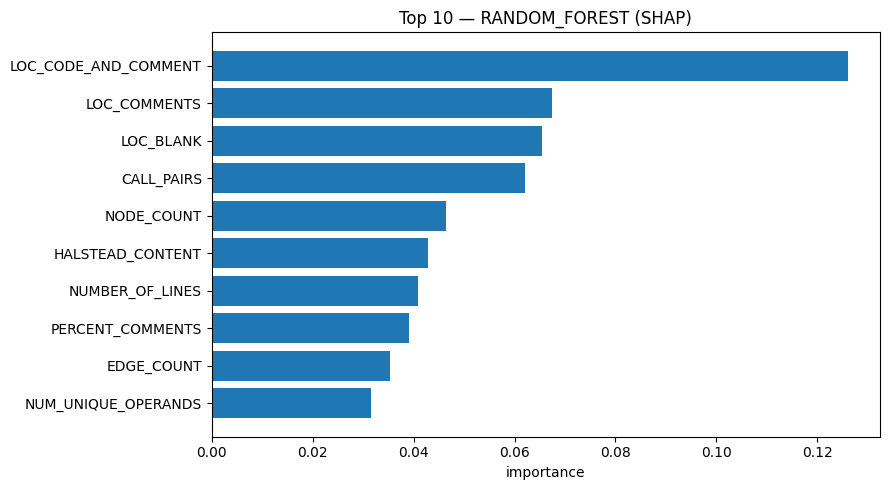

In [13]:
df_mc1, arts_mc1 = run_experiment(dataset="MC1", model_name="random_forest",
    cfg_overrides=dict(fast_mode=True, shap_mode="auto", fast_shap_k=64,
                       shap_eval_size=4000, shap_nsamples=200,
                       perm_repeats=12, concordance_top_k=20,
                       rf_n_estimators=800, rf_max_depth=12))

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9966,0.7316,0.4354,0.5438,0.3855,1.0,0.2867,0.3893,0.7793,0.265


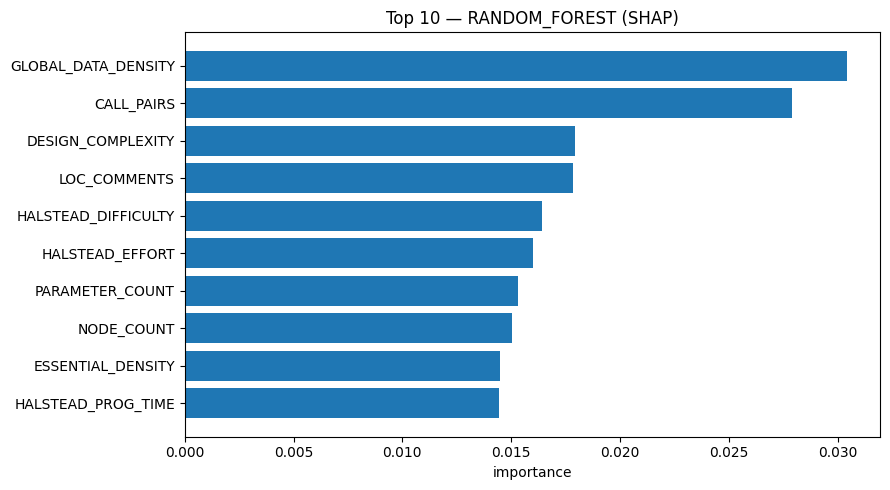

In [8]:
df_mc2, arts_mc2 = run_experiment(dataset="MC2", model_name="random_forest",
    cfg_overrides=dict(fast_mode=True, shap_mode="auto", fast_shap_k=64,
                       shap_eval_size=4000, shap_nsamples=200,
                       perm_repeats=12, concordance_top_k=20,
                       rf_n_estimators=800, rf_max_depth=12))

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.997,0.7888,0.3104,0.3564,0.319,1.0,0.3687,0.7361,0.8508,0.2082


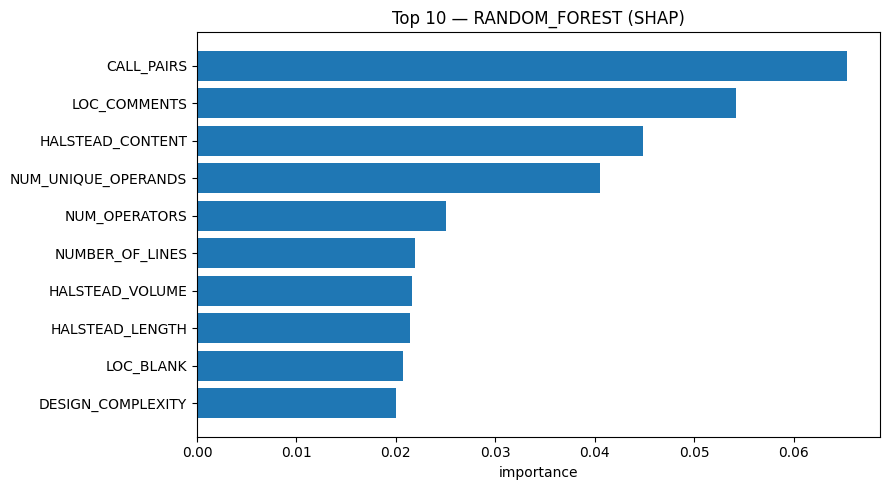

In [10]:
df_mw1, arts_mw1 = run_experiment(dataset="MW1", model_name="random_forest",
    cfg_overrides=dict(fast_mode=True, shap_mode="auto", fast_shap_k=64,
                       shap_eval_size=4000, shap_nsamples=200,
                       perm_repeats=12, concordance_top_k=20,
                       rf_n_estimators=800, rf_max_depth=12))

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9984,0.7438,0.2259,0.2535,0.2444,1.0,0.3535,0.7726,0.8544,0.2546


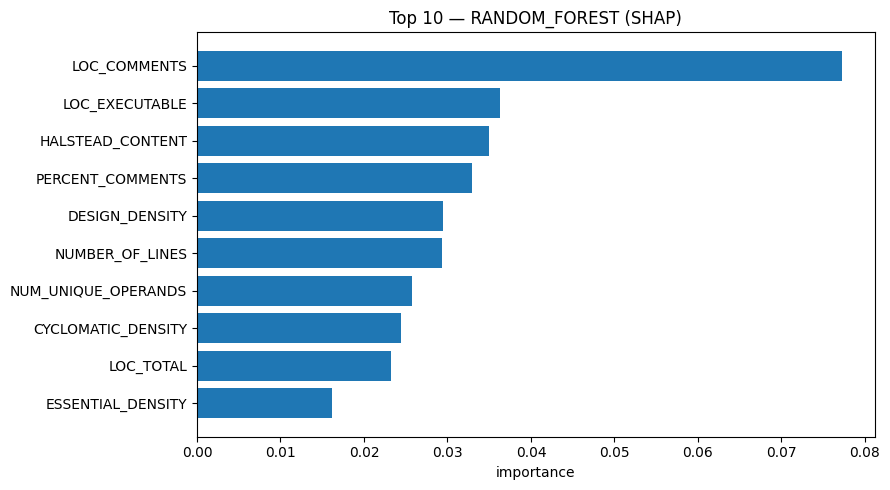

In [11]:
df_cm1, arts_cm1 = run_experiment(dataset="CM1", model_name="random_forest",
    cfg_overrides=dict(fast_mode=True, shap_mode="auto", fast_shap_k=64,
                       shap_eval_size=4000, shap_nsamples=200,
                       perm_repeats=12, concordance_top_k=20,
                       rf_n_estimators=800, rf_max_depth=12))

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.997,0.8646,0.3909,0.3682,0.4292,1.0,0.6203,0.8825,0.9171,0.1324


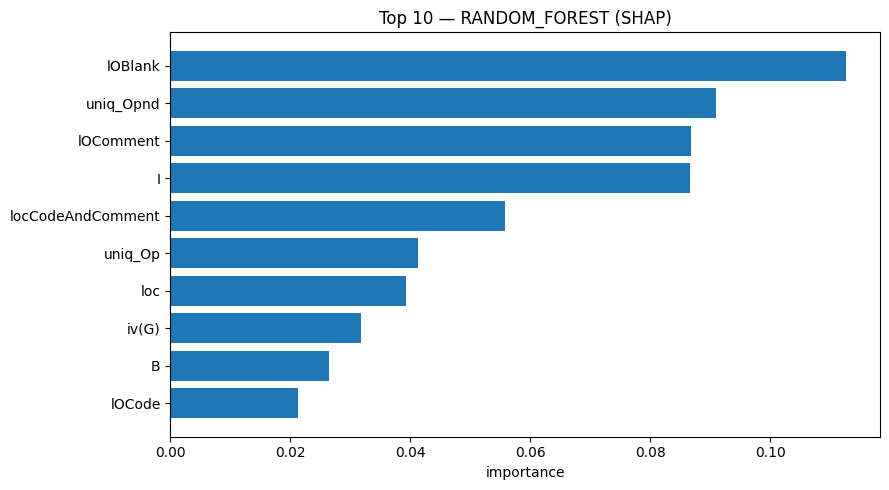

In [12]:
df_pc1, arts_pc1 = run_experiment(dataset="PC1", model_name="random_forest",
    cfg_overrides=dict(fast_mode=True, shap_mode="auto", fast_shap_k=64,
                       shap_eval_size=4000, shap_nsamples=200,
                       perm_repeats=12, concordance_top_k=20,
                       rf_n_estimators=800, rf_max_depth=12))

  0%|          | 0/1118 [00:00<?, ?it/s]

  0%|          | 0/1118 [00:00<?, ?it/s]

  0%|          | 0/1118 [00:00<?, ?it/s]

  0%|          | 0/1118 [00:00<?, ?it/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9909,0.9011,0.0766,0.05,0.17,1.0,0.418,0.7667,0.8641,0.0898


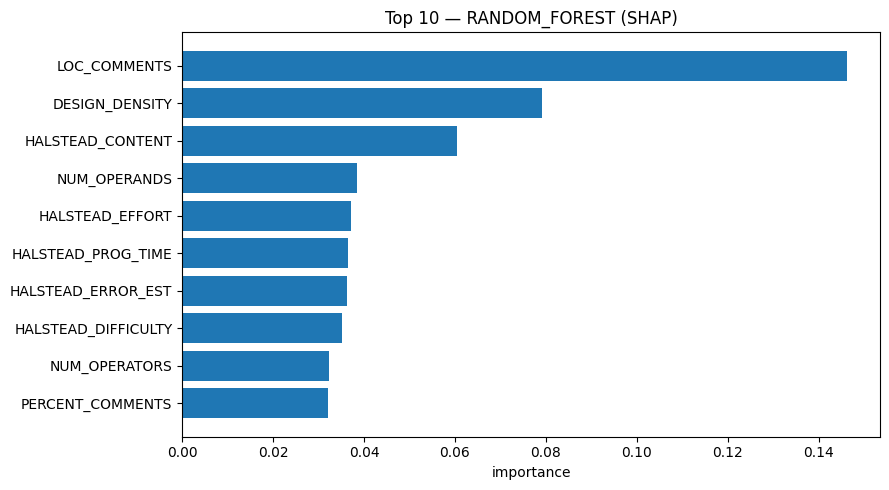

In [14]:
df_pc2, arts_pc2 = run_experiment(dataset="PC2", model_name="random_forest",
    cfg_overrides=dict(fast_mode=True, shap_mode="auto", fast_shap_k=64,
                       shap_eval_size=4000, shap_nsamples=200,
                       perm_repeats=12, concordance_top_k=20,
                       rf_n_estimators=800, rf_max_depth=12))

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9888,0.8423,0.4066,0.3536,0.4812,1.0,0.6136,0.8515,0.9109,0.1466


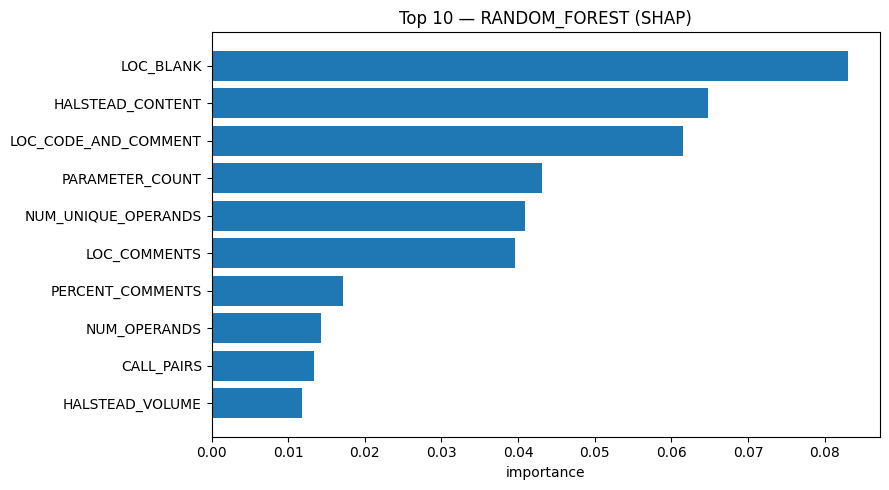

In [15]:
df_pc3, arts_pc3 = run_experiment(dataset="PC3", model_name="random_forest",
    cfg_overrides=dict(fast_mode=True, shap_mode="auto", fast_shap_k=64,
                       shap_eval_size=4000, shap_nsamples=200,
                       perm_repeats=12, concordance_top_k=20,
                       rf_n_estimators=800, rf_max_depth=12))

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

,Model,Train_AUC_mean,AUC_mean,F1_mean,Precision_mean,Recall_mean,Generalizability_mean,Concordance_mean,Stability,ReliabilityIndex,OverfitGap
0,random_forest,0.9949,0.9338,0.6327,0.5669,0.7184,1.0,0.4609,0.8969,0.893,0.0611


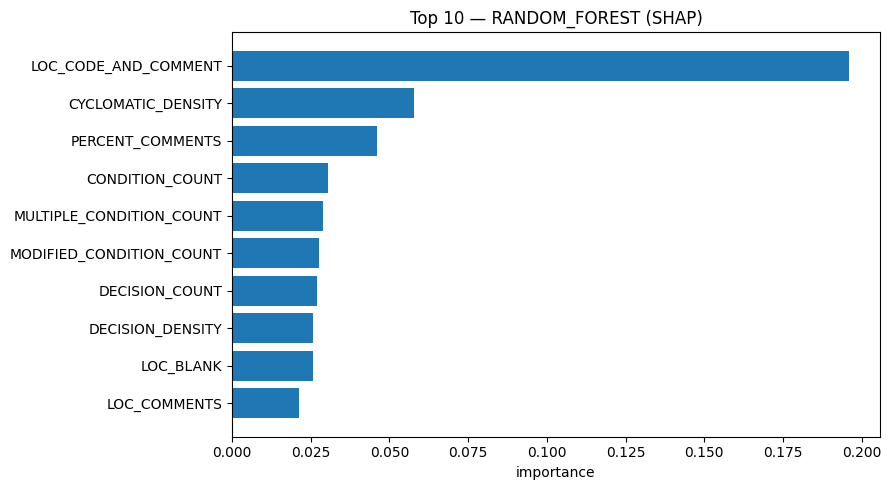

In [16]:
df_pc4, arts_pc4 = run_experiment(dataset="PC4", model_name="random_forest",
    cfg_overrides=dict(fast_mode=True, shap_mode="auto", fast_shap_k=64,
                       shap_eval_size=4000, shap_nsamples=200,
                       perm_repeats=12, concordance_top_k=20,
                       rf_n_estimators=800, rf_max_depth=12))